In [1]:
import fastText
import train_embeddings
import sentence_features
import pickle
from random import shuffle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
# Load mapped reports
labeled_reports_path = "../data/processed/processed_reports/preprocessed_all_replace_sw"
mapped_reports = pickle.load(open(labeled_reports_path, 'rb'))

In [3]:
# Convert mapped reports to correct format
mapped_report_strs = []
for mr in mapped_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    mapped_report_strs.append(report_string + label)
shuffle(mapped_report_strs)

In [4]:
split_point = int(0.9 * len(mapped_report_strs))
train = mapped_report_strs[:split_point]
test = mapped_report_strs[split_point:]

test_data = [t.split("__label__")[0] for t in test]
test_labels = [int(t.split("__label__")[1]) for t in test]

train_path = "../data/processed/processed_reports/ftTRAIN"
with open(train_path, 'w') as outfile:
    for mrs in train:
        outfile.write(mrs)
        outfile.write("\n")

In [5]:
# Train classifier
model = fastText.train_supervised(train_path, dim=400, epoch=25, thread=4, neg=8, lr=0.05)

In [6]:
model.get_words()

['left',
 'right',
 '</s>',
 'normal',
 'RISK',
 'mild',
 'within',
 'SCREEN',
 'NEGEX_evidence',
 'unremarkable',
 'bilateral',
 'unchanged',
 'small',
 'measuring',
 'seen',
 'bones',
 'prior',
 'liver',
 'mass',
 'new',
 'soft_tissues',
 'status_post',
 'anterior',
 'posterior',
 'lesion',
 'moderate',
 'NEGEX_suspicious',
 'series_image',
 'soft_tissue',
 'HX',
 'multiple',
 'noted',
 'NEGEX_acute',
 'lobe',
 'size',
 'fracture',
 'NEGEX_significant',
 'findings',
 'associated',
 'pain',
 'lymphadenopathy',
 'measures',
 'compared',
 'large',
 'along',
 'ct',
 'enhancement',
 'increased',
 'disease',
 'mri',
 'narrowing',
 'patent',
 'right_lower',
 'adjacent',
 'PT',
 'lesions',
 'distal',
 'likely',
 'edema',
 'stable',
 'fluid',
 'lateral',
 'artery',
 'visualized',
 'severe',
 'adrenal_glands',
 'level',
 'compatible',
 'inferior',
 'consistent',
 'brain',
 'changes',
 'neck',
 'also',
 'diffuse',
 'RISK_represent',
 'lower',
 'previously',
 'involving',
 'vein',
 'chest',
 'ad

In [7]:
# Make predictions
predictions = [model.predict(s) for s in test_data]
confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]

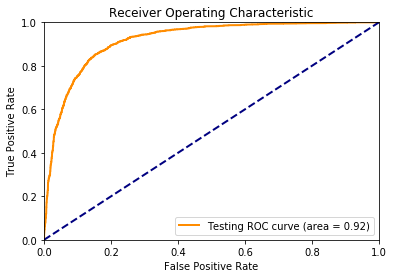

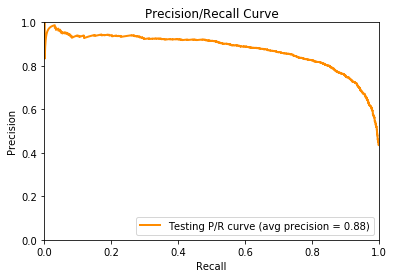

In [8]:
fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(test_labels, confs)
avg_prec = average_precision_score(test_labels, confs)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.2f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()